In [1]:
%matplotlib inline
import SimpleITK
import os
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from segmentation import chan_vese

In [2]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()


# Blood Vessel Reconstruction


This is a blood vessel reconstruction project. There is a main goal which can be broadly divided into 3 steps. Firstly, it is needed to process DICOM images. DICOM images have some noise thus, it should be simplified by segmentation algorithm. And then the image can be used to extract the medial axis by skeletonization algoritm. Secondly, ... Finally, the image can be reconstructed in 3D mesh model.


** Image pre-process step **

In [17]:

#from segmentation import chan_vese
filepath="../resource"
filenames=glob.glob(filepath+'/I0*')

reader=SimpleITK.ImageFileReader()

reader.SetFileName(filenames[0])
itkimage0=reader.Execute()
data0=SimpleITK.GetArrayFromImage(itkimage0)
reader.SetFileName(filenames[1])
itkimage1=reader.Execute()
data1=SimpleITK.GetArrayFromImage(itkimage1)

no=30
targetdata=data0[no]
edges=cv2.Canny(targetdata,100,200)
'''
cv = chan_vese(data1[no], mu=0.1, lambda1=1, lambda2=3, tol=1e-3, max_iter=100,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9),
                         sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

ax=axes.ravel()

ax[0].imshow(data0[no], cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(data1[no], cmap=plt.cm.gray)
ax[1].axis('off')
ax[2].imshow(cv[0], cmap=plt.cm.gray)
ax[2].axis('off')
ax[3].imshow(edges, cmap=plt.cm.gray)
ax[3].axis('off')
'''

'\ncv = chan_vese(data1[no], mu=0.1, lambda1=1, lambda2=3, tol=1e-3, max_iter=100,\n               dt=0.5, init_level_set="checkerboard", extended_output=True)\n\nfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9),\n                         sharex=True, sharey=True,\n                         subplot_kw={\'adjustable\': \'box-forced\'})\n\nax=axes.ravel()\n\nax[0].imshow(data0[no], cmap=plt.cm.gray)\nax[0].axis(\'off\')\nax[1].imshow(data1[no], cmap=plt.cm.gray)\nax[1].axis(\'off\')\nax[2].imshow(cv[0], cmap=plt.cm.gray)\nax[2].axis(\'off\')\nax[3].imshow(edges, cmap=plt.cm.gray)\nax[3].axis(\'off\')\n'

In [18]:
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage import morphology

ret,thres=cv2.threshold(targetdata,120,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#ret,thres=cv2.threshold(data0[no],120,255,cv2.THRESH_BINARY)
edges=cv2.Canny(targetdata,170,200)
fill=ndi.binary_fill_holes(edges)
mark=sobel(targetdata)
img_c=morphology.remove_small_objects(edges,300)
'''
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 9),
                         sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})


ax=axes.ravel()
ax[0].imshow(edges, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(mark, cmap=plt.cm.gray)
ax[1].axis('off')
'''

"\nfig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 9),\n                         sharex=True, sharey=True,\n                         subplot_kw={'adjustable': 'box-forced'})\n\n\nax=axes.ravel()\nax[0].imshow(edges, cmap=plt.cm.gray)\nax[0].axis('off')\nax[1].imshow(mark, cmap=plt.cm.gray)\nax[1].axis('off')\n"

(-0.5, 511.5, 511.5, -0.5)

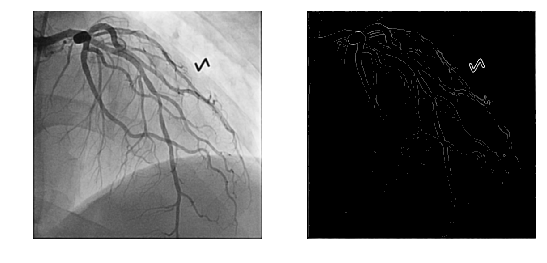

In [20]:
#boun=SimpleITK.BinaryThreshold(itkimage1[no],0,255,1,0)

blurred = cv2.GaussianBlur(targetdata, (5, 5), 0)
sobelX = cv2.Sobel(blurred, cv2.CV_16S, 1, 0)
sobelY = cv2.Sobel(blurred, cv2.CV_16S, 0, 1)
sobel = np.hypot(sobelX, sobelY)/255

sobel2=sobel.copy()
sobel2[sobel2<=0.4]=0

element=cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
mask=cv2.erode(sobel2,element,iterations=1)
mask2=cv2.dilate(mask,element, iterations=1)
mask3=cv2.erode(mask2,element)
mask4=mask3.copy()
mask4[mask4>0]=1
#cv2.imshow('image',sobel)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 9),
                         sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})


ax=axes.ravel()
ax[0].imshow(blurred, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(mask3, cmap=plt.cm.gray)
ax[1].axis('off')

In [7]:
sobel.astype(float)
cv2.imshow('image',sobel/255)

In [9]:
import sys

boun=SimpleITK.BinaryThreshold(data1[no],0,upperThreshold,1,0)
boun2=SimpleITK.BinaryMorphologicalColosing(boun)
boun3=SimpleITK.BinaryGrindPeak(boun2)
boun4=SimpleITK.Cast(boun3, image.GetPixelID())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9),
                         sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax[0].imshow(boun, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(boun2, cmap=plt.cm.gray)
ax[1].axis('off')
ax[0].imshow(boun3, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(boun4, cmap=plt.cm.gray)
ax[4].axis('off')

plt.show()

NameError: name 'upperThreshold' is not defined

**Medial axis skeletonization**

The medial axis of an object is the set of all points having more than one
closest point on the object's boundary. It is often called the *topological
skeleton*, because it is a 1-pixel wide skeleton of the object, with the same
connectivity as the original object.

Here, we use the medial axis transform to compute the width of the foreground
objects. As the function ``medial_axis`` returns the distance transform in
addition to the medial axis (with the keyword argument ``return_distance=True``),
it is possible to compute the distance to the background for all points of
the medial axis with this function. This gives an estimate of the local width
of the objects.

For a skeleton with fewer branches, ``skeletonize`` or ``skeletonize_3d``
should be preferred.



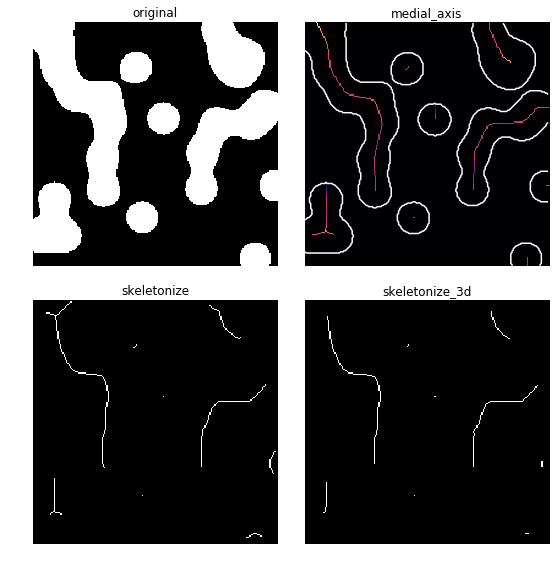

In [10]:
from skimage.morphology import medial_axis, skeletonize, skeletonize_3d
from skimage.data import binary_blobs

# Generate the data
data = binary_blobs(200, blob_size_fraction=.2, volume_fraction=.35, seed=1)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(data, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(data)
skeleton3d = skeletonize_3d(data)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

from skimage.util.colormap import magma

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(data, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap=magma, interpolation='nearest')
ax[1].contour(data, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton3d, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('skeletonize_3d')
ax[3].axis('off')

fig.tight_layout()
plt.show()